## Project Title: <b><i>Housing in Buenos Aires</i></b>

## <b>Project Overview</b>
#### In this project, I'll build on data wrangling and visualization skills and move from descriptive to predictive data science. my focus is to create a machine learning model that predicts apartment prices in Buenos Aires properties ("Capital Federal"). In this project, I'm working for a client who wants to create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400,000 USD.

### <span style="color:orange">Import all required libraries </span>

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder

from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

##### <span style="color:red">Task 1</span>: Write a function named wrangle that takes a file path as an argument and returns a DataFrame.

In [40]:
def wrangle(filepath):
    df= pd.read_csv(filepath)
    
    # Task7: Subset to `"apartment"`
    mask_apt= df["property_type"]=="apartment"
    
    # Task 7: Subset to properties in `"Capital Federal"`
    mask_cf= df["place_with_parent_names"].str.contains("Capital Federal")
    
    # Task 7: Subset to properties `price_aprox_usd < 250_000`
    mask_price= df["price_aprox_usd"]< 400_000

    # Task 10: Remove outliers by "surface_covered_in_m2"
    low, high= df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area= df["surface_covered_in_m2"].between(low, high)
    
    #Task 13: # Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|", expand=True)[3]
    
    # Task 13: Drop "place_with_parent_names" column
    df.drop(columns=["place_with_parent_names"], inplace=True)
    
    # Task 16: Drop features with high null counts
    df.drop(columns=["floor","expenses"], inplace= True)
    
    # Task 18: Drop low- and High-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "properati_url", "currency", "lat-lon"], inplace=True)

    # Task 19: Drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"], inplace=True)

    # Drop columns with multicollinearity
    df.drop(columns=["rooms", "surface_total_in_m2"], inplace=True)
    
    df= df[mask_apt & mask_cf & mask_price & mask_area]
    
    
    return df

##### <span style="color:red">Task 2</span>: Use <b>glob</b> to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files.

##### <b> <span style="color:orange">Collect file names</span> </b>

In [4]:
files= glob("C:/Users/Jean Paul/Desktop/Mine/Data Science/Datasets/buenos-aires-real-estate-*")

##### <span style="color:red">Task 3</span>: Use your <b>wrangle</b> function in a list comprehension to create a list named <b>frames</b>. The list should contain the cleaned DataFrames for the filenames your collected in <b>files</b>.

##### <b><span style="color:orange">Wrangle with List Comprehension</span></b>

In [6]:
frames= [wrangle(file) for file in files]

##### <span style="color:red">Task 4</span>: Use <b>pd.concat</b> to concatenate it items in frames into a single DataFrame <b>df_concat</b>.

##### <b><span style="color:orange">Concatenate DataFrames</span></b>

In [7]:
df_concat= pd.concat(frames, ignore_index=True)

##### <span style="color:red">Task 5</span>: Save <b>df_concat</b> as a CSV file using the <b>to_csv</b> method. The file path should be <b>"./Datasets/buenos-aires-real-estate-concat.csv"</b>.

##### <b><span style="color:orange">Saving DataFrames as CSV</span></b>

In [8]:
df_concat.to_csv("C:/Users/Jean Paul/Desktop/Mine/Data Science/Datasets/buenos-aires-real-estate-concat.csv", index=False)

### <span style="color:blue"><b>I. PREPARE DATA</b></span>

##### <span style="color:blue"><b>I.a IMPORT</b></span>

##### <span style="color:red">Task 6</span>: Use your <b>wrangle</b> function to create a DataFrame <b>df</b> from the CSV file <b>Datasets/data/buenos-aires-real-estate-concat.csv</b>.

##### <b><span style="color:orange">Import CSV</span></b>

In [41]:
df= wrangle("C:/Users/Jean Paul/Desktop/Mine/Data Science/Datasets/buenos-aires-real-estate-concat.csv")
df.head(2)

,price_aprox_usd,surface_covered_in_m2,neighborhood
0,180000.0,110.0,Villa Crespo
4,129000.0,70.0,Chacarita


##### <span style="color:red">Task 7</span>: Add to your <b>wrangle</b> function so that the DataFrame it returns only includes <b>apartments</b> in Buenos Aires (<b>"Capital Federal"</b>) that cost less than <b>$300,000 USD</b>.

In [23]:
df.shape

(2788, 9)

##### <span style="color:blue"><b>I.b EXPLORE</b></span>

#### <span style="color:blue"> <ins><b>Predicting Price with Size</b></ins>

##### <span style="color:red">Task 8</span>: Create a histogram of <b>"surface_covered_in_m2"</b>. Make sure that the x-axis has the label <b>"Area [sq meters]"</b> and the plot has the title <b>"Distribution of Apartment Sizes"</b>.

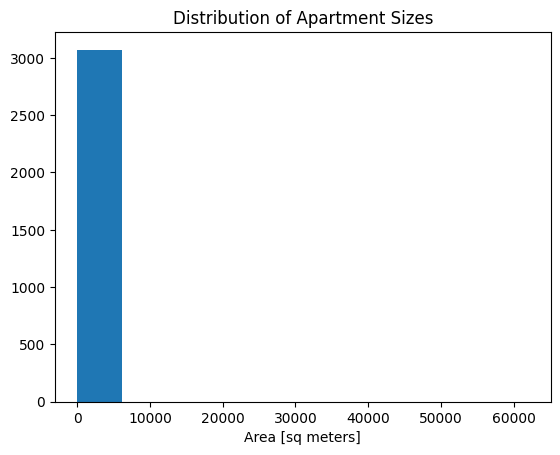

In [26]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

##### <span style="color:green">Task 8 Result Interpretation</span>: an histogram like the one above suggests that there are outliers in your dataset. This can affect model performance — especially in the sorts of linear models. To confirm, let's look at the summary statistics for the <b>"surface_covered_in_m2"</b> feature. 

##### <span style="color:red">Task 9</span>: Calculate the summary statistics for <b>df</b> using the <b>describe</b> method.

In [5]:
df.describe()["surface_covered_in_m2"]

count    2788.000000
mean       64.235653
std        30.454883
min        34.000000
25%        42.000000
50%        55.000000
75%        77.000000
max       274.000000
Name: surface_covered_in_m2, dtype: float64

##### <span style="color:green">Task 9 Result Interpretation</span>: The statistics above confirm what we suspected. While most of the apartments in our dataset are smaller that 77 square meters, there are some that are several thousand square meters. The best thing to do is to change our <b>wrangle</b> function and remove them from the dataset.

##### <span style="color:red">Task 10</span>: Add to your wrangle function so that it removes observations that are outliers in the "surface_covered_in_m2" column. Specifically, all observations should fall between the <b>0.1</b> and <b>0.9</b> quantiles for <b>"surface_covered_in_m2"</b>.

##### <span style="color:red">Task 11</span>: When you're done, redo Task Task 8 and notice how your histogram changes now that there are no outliers. At this point, df should have less observations than before.

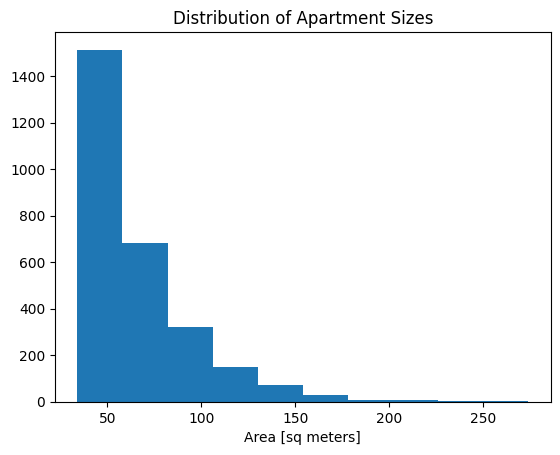

In [6]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartment Sizes");

##### <span style="color:red">Task 12</span>: Create a horizontal boxplot of <b>"surface_covered_in_m2"</b>. Make sure that the x-axis has the label <b>"Area [sq meters]"</b> and the plot has the title <b>"Distribution of Home Sizes"</b>. How is the distribution and its left skew represented differently here than in your histogram?

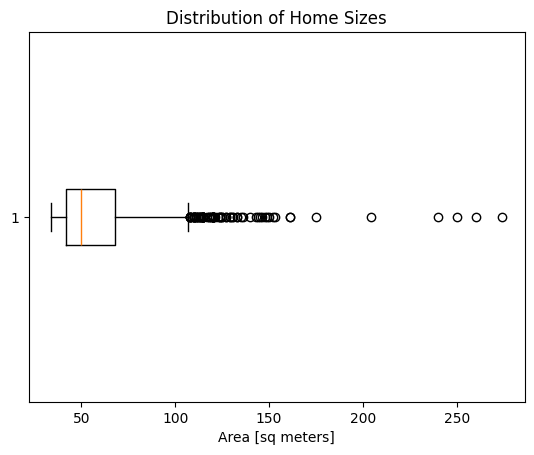

In [21]:
plt.boxplot(df["surface_covered_in_m2"], vert=False)
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Home Sizes");

##### <span style="color:green">Task 12 Result Interpretation</span>: This boxplot illustrates the distribution of home sizes (in square meters). Most homes fall within a compact range around the median (shown by the box), while larger homes are outliers beyond 150 sq meters. These outliers might influence price predictions, and depending on your model, you may need to address them for improved performance.

##### <span style="color:red">Task 13</span>: Create a scatter plot that shows price (<b>"price_aprox_usd"</b>) vs area (<b>"surface_covered_in_m2"</b>) in our dataset. Make sure to label your x-axis <b>"Area [sq meters]"</b> and your y-axis <b>"Price [USD]"</b>.

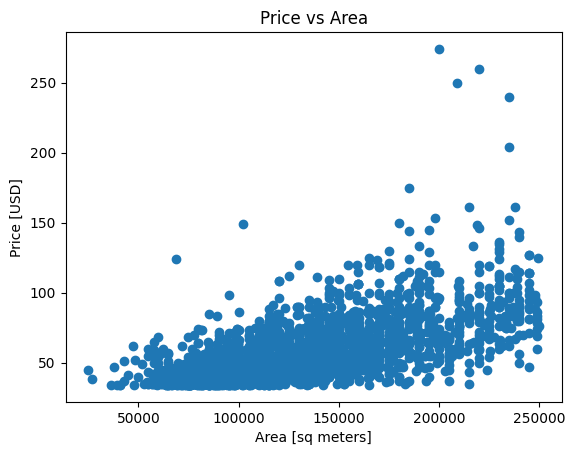

In [13]:
plt.scatter(x=df["price_aprox_usd"], y=df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Price vs Area");

##### <span style="color:green">Task 13 Result Interpretation</span>: This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

#### <span style="color:blue"> <ins><b>Predicting Price with Neighborhood</b></ins>

##### <span style="color:red">Task 14</span>: Modify a <b>wrangle</b> function to create a new feature <b>"neighborhood"</b>. Find the neighborhood for each property in the <b>"place_with_parent_names"</b> column. For example, a property with the place name <b>"|Argentina|Capital Federal|Palermo|"<b> is located in the neighborhood is <b>"Palermo"</b>. Also, a function should drop the <b>"place_with_parent_names"</b> column.

##### <span style="color:red">Task 15</span>: First, use the <b>groupby</b> method to create a Series where the index contains each neighborhood in the dataset and the values correspond to the mean of price_aprox_usd for that neighborhood. Then use the Series to create a bar chart of your results. Make sure the states are sorted from the highest to lowest mean, that you label the x-axis as <b>"neighborhood"</b> and the y-axis as <b>"Mean Price of price_aprox_usd [USD]"</b>, and give the chart the title <b>"Mean House Price by neighborhood"</b>.

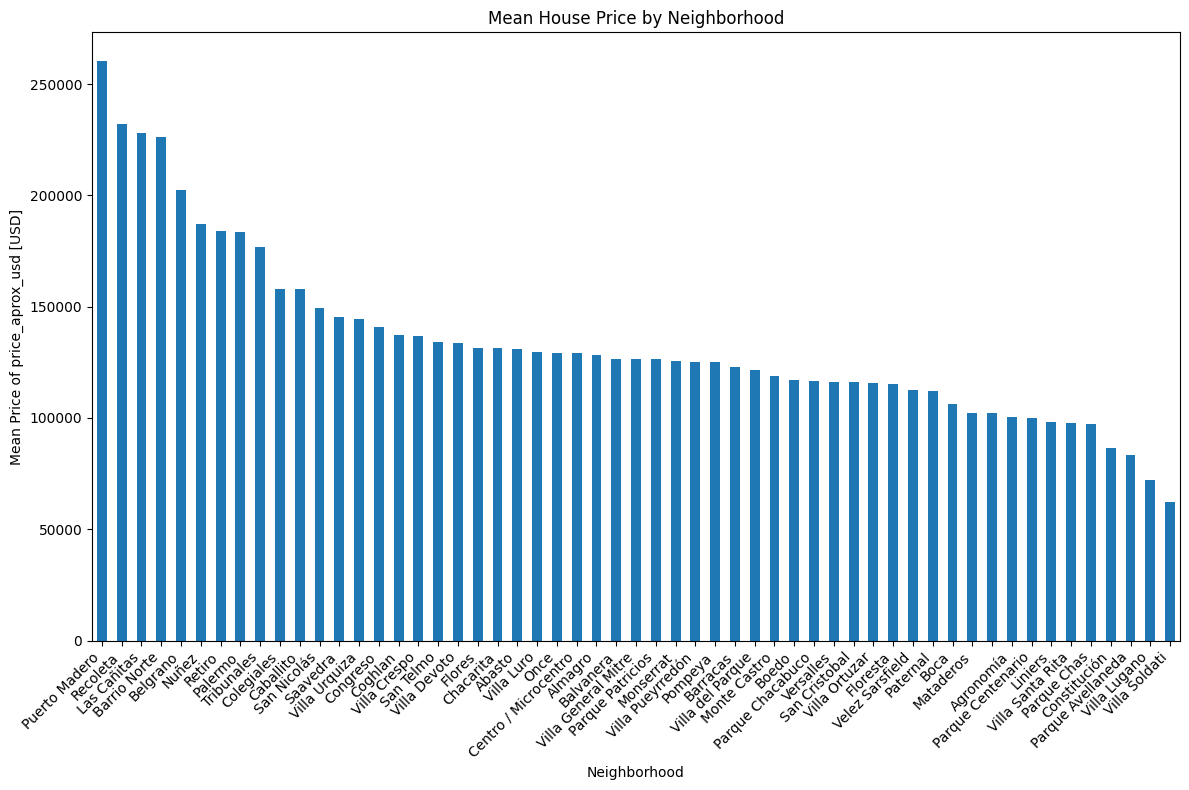

In [7]:
# Group `df` by "neighborhood", create bar chart of "price_aprox_usd"
plt.figure(figsize=(12, 8))  # Increase figure size for better spacing
(
    df
    .groupby("neighborhood")["price_aprox_usd"].mean().sort_values(ascending=False)
    .plot(
        kind="bar",
        xlabel="Neighborhood",
        ylabel="Mean Price of price_aprox_usd [USD]",
        title="Mean House Price by Neighborhood"
    )
);
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()

##### <span style="color:green">Task 15 Result Interpretation</span>: This bar chart displays the mean house price by neighborhood. It shows significant variation, with <b><i>Puerto Madero</i></b> having the highest average prices, while neighborhoods like <b><i>Villa Soldati</i></b> have the lowest. This highlights how location strongly influences property values.

In [13]:
df.isnull().sum()

operation                        0
property_type                    0
lat-lon                         99
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2            824
surface_covered_in_m2            0
price_usd_per_m2               908
price_per_m2                     0
floor                         1958
rooms                          512
expenses                      2041
properati_url                    0
neighborhood                     0
dtype: int64

##### The first thing we need to consider when trying to use all the features df is <b>missing values</b>. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.
##### Take a look at the output from <b>df.info() </b>above. Are there columns where more than half of the values are <b>NaN</b>? If so, those columns need to go!

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2788 entries, 0 to 17191
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2788 non-null   object 
 1   property_type               2788 non-null   object 
 2   lat-lon                     2689 non-null   object 
 3   price                       2788 non-null   float64
 4   currency                    2788 non-null   object 
 5   price_aprox_local_currency  2788 non-null   float64
 6   price_aprox_usd             2788 non-null   float64
 7   surface_total_in_m2         1964 non-null   float64
 8   surface_covered_in_m2       2788 non-null   float64
 9   price_usd_per_m2            1880 non-null   float64
 10  price_per_m2                2788 non-null   float64
 11  floor                       830 non-null    float64
 12  rooms                       2276 non-null   float64
 13  expenses                    747 non-n

##### <span style="color:red">Task 16</span>: Modify your <b>wrangle</b> function to drop any columns that are more than half <b>NaN</b> values. 

In [14]:
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
lat-lon                       0.035509
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.295552
surface_covered_in_m2         0.000000
price_usd_per_m2              0.325681
price_per_m2                  0.000000
floor                         0.702296
rooms                         0.183644
expenses                      0.732066
properati_url                 0.000000
neighborhood                  0.000000
dtype: float64

##### <span style="color:red">NB</span>:The next thing we need to look out for are categorical columns with <b>low or high cardinality</b>. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.
##### Let's take a look at the cardinality of our features.

##### <span style="color:red">Task 17</span>: Calculate the number of unique values for each non-numeric feature in <b>df</b>.

In [19]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
lat-lon          2227
currency            2
properati_url    2788
neighborhood       55
dtype: int64

##### <span style="color:red">NB</span>: Here, we can see that columns like <b>"operation"</b> have only one value in them, while every row in <b>"properati_url"</b> has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

##### <span style="color:red">Task 18</span>: Modify your <b>wrangle</b> function to drop high- and low-cardinality categorical features.

##### <span style="color:red">NB</span>: It's also important for us to drop any columns that would constitute <b>leakage</b>, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

##### <span style="color:red">Task 19</span>: Modify your <b>wrangle</b> function to drop any features that would constitute leakage.

##### <span style="color:red">NB</span>: Finally, the last issue we need to keep an eye out for is <b>multicollinearity</b>, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

In [27]:
df.select_dtypes("number").drop(columns="price_aprox_usd").head(2)


,surface_total_in_m2,surface_covered_in_m2,rooms
0,120.0,110.0,4.0
4,76.0,70.0,NaN


In [28]:
df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

,surface_total_in_m2,surface_covered_in_m2,rooms
surface_total_in_m2,1.000000,0.820341,0.643341
surface_covered_in_m2,0.820341,1.000000,0.769375
rooms,0.643341,0.769375,1.000000


##### <span style="color:red">Task 20</span>: Plot a correlation heatmap of the remaining numerical features in <b>df</b>. Since <b>"price_aprox_usd"</b> will be your target, you don't need to include it in your heatmap.

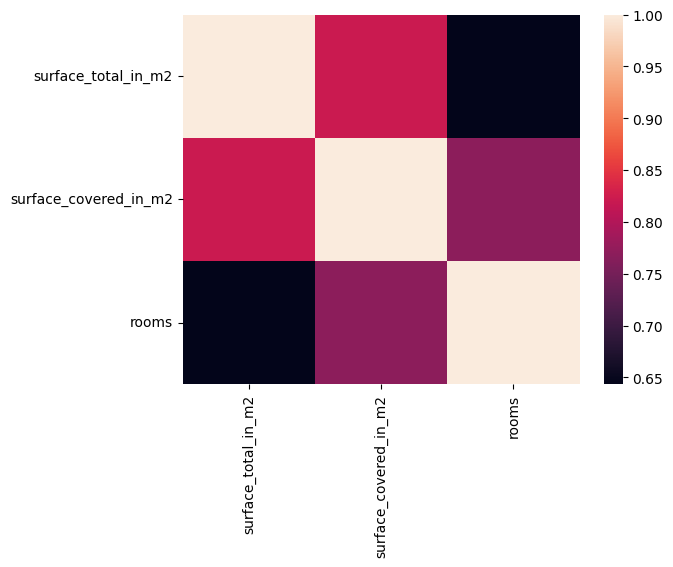

In [33]:
corr= df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

##### <span style="color:red">Task 20</span>: Modify your <b>wrangle</b> function to remove columns so that there are no strongly correlated features in your feature matrix.

#### Renaming feature's names

In [43]:
df.rename(columns={'price_aprox_usd': 'price_usd', 'surface_covered_in_m2': 'surface_m2'}, inplace=True)

In [44]:
sorted(df.columns)

['neighborhood', 'price_usd', 'surface_m2']

##### <span style="color:blue"><b>I.c SPLIT: Train-test split</b></span>

###### <span style="color:blue"><b><ins>Vertical Split</ins></b></span>

In [45]:
target="price_usd"
y= df[target]
X= df.drop(columns=target)

###### <span style="color:blue"><b><ins>Train-Test Split</ins></b></span>

In [61]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [62]:
len(X)== len(X_train) + len(X_test)

True

### <span style="color:blue"><b>II. BUILD MODEL</b></span>

##### <span style="color:blue"><b>II.a Baseline Model</b></span>

##### <span style="color:red">NB</span>: The first step in building a model is baselining. To do this, ask yourself how you will know if the model you build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of an apartment's size. So let's start by figuring out what our baseline model's prediction should be.

##### <span style="color:red">Task 21</span>: Calculate the mean of your target vector <b>y_train</b> and assign it to the variable <b>y_mean</b>.

In [63]:
y_mean= y_train.mean()
print("Mean apartment price: ", round(y_mean, 2))

Mean apartment price:  153150.13


##### <span style="color:red">NB</span>: Now that we have the one prediction that our dumb model will always make, we need to generate a list that repeats the prediction for every observation in our dataset.

##### <span style="color:red">Task 22</span>: Create a list named <b>y_pred_baseline</b> that contains the value of <b>y_mean</b> repeated so that it's the same length at y.

In [64]:
y_pred_baseline= [y_mean] * len(y_train)
y_pred_baseline[:5]

[np.float64(153150.12769058297),
 np.float64(153150.12769058297),
 np.float64(153150.12769058297),
 np.float64(153150.12769058297),
 np.float64(153150.12769058297)]

In [57]:
len(y_pred_baseline) == len(y_train)

True

##### <span style="color:red">NB</span>: So how does our baseline model perform? One way to evaluate it is by plotting it on top of the scatter plot we made above.

##### <span style="color:red">Task 23</span>:  Add a line to the plot below that shows the relationship between the observations <b>X_train</b> and our dumb model's predictions <b>y_pred_baseline</b>. Be sure that the line color is orange, and that it has the label <b>"Baseline Model"</b>

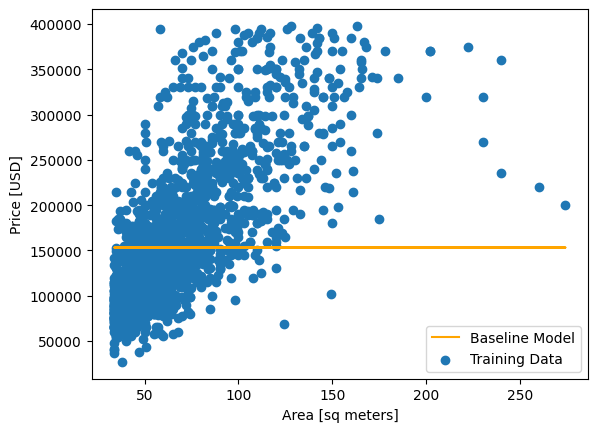

In [65]:
# Plot the baseline model predictions
plt.plot(X_train["surface_m2"], y_pred_baseline, color="orange", label="Baseline Model")

# Scatter plot of the training data
plt.scatter(X_train["surface_m2"], y_train, label="Training Data")

# Adding labels and legend
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.legend()

# Display the plot
plt.show()

##### <span style="color:green">Task 23 Result Interpretation</span>: Looking at this visualization, it seems like our baseline model doesn't really follow the trend in the data. But, as a data scientist, you can't depend only on a subjective plot to evaluate a model. You need an exact, mathematically calculate <b>performance metric</b>. There are lots of performance metrics, but the one we'll use here is the <b>mean absolute error</b>.

##### <span style="color:red">Task 24</span>: Calculate the baseline mean absolute error for your predictions in <b>y_pred_baseline</b> as compared to the true targets in <b>y</b>.

In [66]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 153150.13
Baseline MAE: 58355.5


##### <span style="color:green">Task 24 Result Interpretation</span>: What does this information tell us? If we always predicted that an apartment price is USD 153,150.13, our predictions would be off by an average of USD 58,355.5. It also tells us that our model needs to have mean absolute error below USD 58,355.5 in order to be useful.

##### <span style="color:red">NB</span>: The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance. Even though the model we're building is linear, the iteration process rarely follows a straight line.

##### The first thing we need to do is create our model — in this case, one that uses linear regression.

##### <span style="color:blue"><b>II.b Iterate</b></span>

##### <span style="color:red">NB1</span>: Look at the values in the <b><i>"Non-Null Count" using df.info()</i></b> column. Because of the math it uses, a linear regression model can't handle observations where there are missing values.

##### Mostly, we simply dropped rows that contained <b><i> NaN</i></b> values, but this isn't ideal. Models generally perform better when they have more data to train with, so every row is precious. Instead, we can fill in these missing values using information we get from the whole column — a process called <b>imputation</b>. There are many different strategies for imputing missing values, and one of the most common is filling in the missing values with the mean of the column.

##### In addition to predictors like <b><i>LinearRegression </i></b>, scikit-learn also has <b>transformers</b> that help us deal with issues like missing values.
##### Just like a predictor, a transformer has a <b>fit</b> method. In the case of our <b>SimpleImputer</b>, this is the step where it calculates the mean values for each numerical column.

##### <span style="color:red">NB2</span>: If you try to fit a LinearRegression predictor to your training data at this point, you'll get an error.
##### What does this mean? When you fit a linear regression model, you're asking scikit-learn to perform a mathematical operation. The problem is that our training set contains neighborhood information in non-numerical form. In order to create our model we need <b>to encode</b> that information so that it's represented numerically. The good news is that there are lots of transformers that can do this. Here, we'll use the one from the <i>Category Encoders</i> library, called a <b><i>OneHotEncoder</i></b>.

##### <span style="color:red">Task 25</span>:  Create a pipeline named <b>model</b> that contains a <b>OneHotEncoder, SimpleImputer</b>, and <b>Ridge predictor</b>.

In [69]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

##### <span style="color:blue"><b>II.c Evaluate</b></span>

##### <span style="color:red">NB</span>: The final step is to evaluate our model. In order to do that, we'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in our training set.

##### <span style="color:red">Task 26</span>: Using your model's <b>predict</b> method, create a list of predictions for the observations in your feature matrix X_train. Name this array <b>y_pred_training</b>.

In [72]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([230173.28349953, 164243.71194606,  96603.12271946, 139494.38004028,
        69982.5894318 ])

##### <span style="color:red">NB</span>: Now that we have predictions, we'll use them to assess our model's performance with the training data. We'll use the same metric we used to evaluate our baseline model: mean absolute error.

##### <span style="color:red">Task 27</span>: Calculate your training mean absolute error for your predictions in <b>y_pred_training</b> as compared to the true targets in <b>y_train</b>.

In [73]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 27886.33


##### <span style="color:green">Task 27 Result Interpretation</span>:Good news: Our model beat the baseline by over $30,000! That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that we call the <b>test set</b>.

##### <span style="color:red">Task 28</span>: Run the code below to import your test data into a DataFrame.

In [74]:
mae_test= mean_absolute_error(y_test, model.predict(X_test))
print("MAE Test: ", round(mae_test, 2))

MAE Test:  31820.74


##### My model's mean absolute error is 31,820.74. 

##### <i>Ideally, you want your test performance metrics to be the same as its training performance metrics. In practice, test metrics tend to be a little worse (this means a larger number in the case of mean absolute error). But as long as the training and test performance are close to each other, you can be confident that your model will generalize well.</i>

##### <span style="color:red"><b><ins>Warning</ins></b></span>: <span style="color:red">During the iteration phase, you can change and retrain your model as many times as you want. You can also check the model's training performance repeatedly. But once you evaluate its test performance, you can't make any more changes.</span>

##### <span style="color:red">A test only counts if neither the model nor the data scientist has seen the data before. If you check your test metrics and then make changes to the model, you can introduce biases into the model that compromise its generalizability.</span>

### <span style="color:blue"><b>III.COMMUNICATE RESULTS</b></span>

##### <span style="color:red">NB</span>: Once your model is built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation.

##### <span style="color:blue"><b>III.a: Prediction Function</b></span>

In [75]:
def make_prediction(area, neighborhood):
    data = {
        "surface_m2": area,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])

    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

##### Testing if the function works as intended

In [76]:
make_prediction(111, "Villa Crespo")

'Predicted apartment price: $231991.1'

##### <span style="color:blue"><b>III.b Interactive Dashboard MVP</b></span>

In [79]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_m2"].min(),
        max=X_train["surface_m2"].max(),
        value=X_train["surface_m2"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=64, description='area', max=274, min=34), Dropdown(description='neighbor…